## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import seaborn as sns


%matplotlib inline

## Importing necessary movie dataset

In [2]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


Column represent each unique userId and each row represents each unique movieId.

## Dealing with NaN values

In [6]:
final_dataset.isna().sum()

userId
1      9492
2      9695
3      9685
4      9508
5      9680
       ... 
606    8609
607    9537
608    8893
609    9687
610    8422
Length: 610, dtype: int64

There are too many NaN/Null values

In [7]:
final_dataset.fillna(value=0,inplace=True)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
final_dataset.isna().sum()

userId
1      0
2      0
3      0
4      0
5      0
      ..
606    0
607    0
608    0
609    0
610    0
Length: 610, dtype: int64

We'he dealt with all the NaN/Null values

In [9]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [10]:
user_voted_count = ratings.groupby('movieId')['rating'].agg('count')

In [11]:
user_voted_count

movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Name: rating, Length: 9724, dtype: int64

In [12]:
movies_voted_count = ratings.groupby('userId')['rating'].agg('count')
movies_voted_count

userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: rating, Length: 610, dtype: int64

## Visualizing user_voted_count with set thresold 10

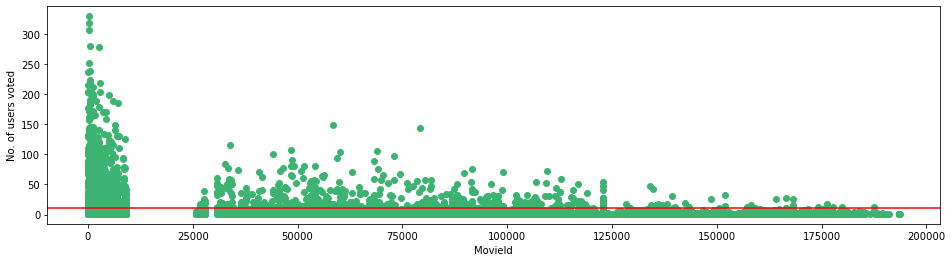

In [13]:
plt.figure(figsize=(16,4))
plt.scatter(user_voted_count.index,user_voted_count,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

## Removing Noise from the dataset

In the real-world, ratings are very sparse and data points are mostly collected from very popular movies and highly engaged users. We wouldn’t want movies that were rated by a small number of users because it’s not credible enough. Similarly, users who have rated only a handful of movies should also not be taken into account.


Threshold for solving this noise problem
- To qualify a movie, a minimum of 10 users should have voted a movie.
- To qualify a user, a minimum of 50 movies should have voted by the user.

In [14]:
final_dataset.head(2)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0


### Taking indexes of those user who are satisfying the set threshold (1)

In [15]:
# We're are now filtering the dataset to take only those movies which have been voted by more than 10 users.
# Our [row,columns] = [movieId, userId]
final_dataset = final_dataset.loc[user_voted_count[user_voted_count > 10].index,:]
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0


In [16]:
len(final_dataset)

2121

## Visualizing movies_voted_count with set thresold 50

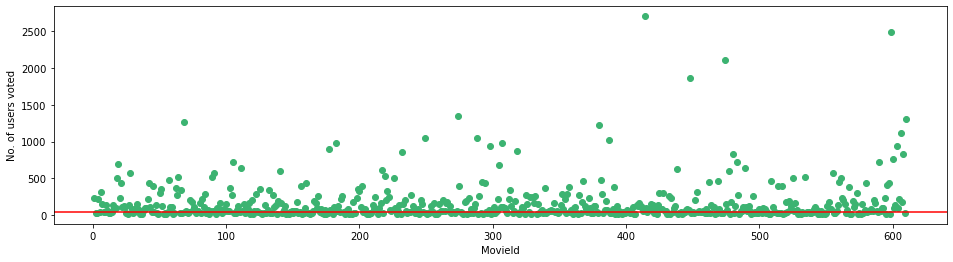

In [17]:
plt.figure(figsize=(16,4))
plt.scatter(movies_voted_count.index,movies_voted_count,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [18]:
movies_voted_count[movies_voted_count > 50]

userId
1       232
4       216
6       314
7       152
10      140
       ... 
605     221
606    1115
607     187
608     831
610    1302
Name: rating, Length: 378, dtype: int64

In [19]:
# We're are now filtering the dataset to take only those users who had voted more than 50 movies.
# Our [row,columns] = [movieId, userId]
final_dataset=final_dataset.loc[:,movies_voted_count[movies_voted_count > 50].index]
final_dataset.head()

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


In [20]:
len(final_dataset)

2121

In [21]:
final_dataset

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Removing Sparsity

In [22]:
sample = np.array([[0,0,3,0,0],
                   [4,0,0,0,2],
                   [0,0,0,0,1]])
# sparsity formula
sparsity = 1.0 - ( np.count_nonzero(sample) / float(sample.size) )
print(sparsity)

0.7333333333333334


In [23]:
csr_sample = csr_matrix(sample)
print(csr_sample)

  (0, 2)	3
  (1, 0)	4
  (1, 4)	2
  (2, 4)	1


As you can see there is no sparse value in the csr_sample and values are assigned as rows and column index. for the 0th row and 2nd column, the value is 3.

#### Applying sparse matrix method csr_matrix to our movie final_dataset

In [24]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

In [25]:
final_dataset

userId,movieId,1,4,6,7,10,11,15,16,17,...,600,601,602,603,604,605,606,607,608,610
0,1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
1,2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
2,3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
4,6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2116,174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2117,176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2118,177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2119,179819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
print(csr_data)

  (0, 0)	4.0
  (0, 3)	4.5
  (0, 6)	2.5
  (0, 8)	4.5
  (0, 9)	3.5
  (0, 10)	4.0
  (0, 12)	3.5
  (0, 16)	3.0
  (0, 19)	3.0
  (0, 20)	3.0
  (0, 25)	5.0
  (0, 28)	5.0
  (0, 29)	4.0
  (0, 31)	3.0
  (0, 34)	5.0
  (0, 38)	5.0
  (0, 39)	4.0
  (0, 40)	4.0
  (0, 41)	2.5
  (0, 43)	4.5
  (0, 46)	0.5
  (0, 47)	4.0
  (0, 50)	2.5
  (0, 53)	4.0
  (0, 55)	3.0
  :	:
  (2118, 205)	4.0
  (2118, 345)	1.5
  (2118, 357)	4.0
  (2118, 369)	4.5
  (2119, 37)	3.5
  (2119, 62)	3.0
  (2119, 98)	0.5
  (2119, 127)	4.5
  (2119, 156)	4.5
  (2119, 236)	0.5
  (2119, 256)	4.5
  (2119, 317)	2.0
  (2119, 345)	2.0
  (2119, 357)	5.0
  (2119, 365)	3.5
  (2120, 37)	4.0
  (2120, 62)	5.0
  (2120, 146)	2.5
  (2120, 155)	4.5
  (2120, 156)	5.0
  (2120, 186)	5.0
  (2120, 205)	4.0
  (2120, 236)	3.0
  (2120, 317)	3.5
  (2120, 357)	4.0


This is how our sparse matrix for the final_dataset looks like

## Recommender system model

In [27]:
knn = NearestNeighbors(n_neighbors=20, metric='cosine', algorithm='brute', n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [28]:
m_list = movies[movies['title'].str.contains('Jumanji')]

In [29]:
m_list

,movieId,title,genres
1,2,Jumanji (1995),Adventure|Children|Fantasy
9636,179401,Jumanji: Welcome to the Jungle (2017),Action|Adventure|Children


In [73]:
def get_movie_recommendation(movie_name):
    num_movies_to_recommend = 10
    # check if the movie_nameis available in the movies dataset
    # and if the movies is available we'll store the data in a list(a DataFrame)
    # for refference look for the example above m_list
    movie_list = movies[movies['title'].str.contains(movie_name)]
    if len(movie_list): # len(movie_list) > 0
        movie_idx = movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=num_movies_to_recommend+1)
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Genre':movies.iloc[idx]['genres'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,num_movies_to_recommend+1))
        return df
    else:
        return "No movies found. Please check your input"

## Let's recommend some movies and test our Recommender System

In [74]:
get_movie_recommendation("Iron Man")

,Title,Genre,Distance
1,Up (2009),Adventure|Animation|Children|Drama,0.368857
2,Guardians of the Galaxy (2014),Action|Adventure|Sci-Fi,0.368758
3,Watchmen (2009),Action|Drama|Mystery|Sci-Fi|Thriller|IMAX,0.368558
4,Star Trek (2009),Action|Adventure|Sci-Fi|IMAX,0.366029
5,Batman Begins (2005),Action|Crime|IMAX,0.362759
6,Avatar (2009),Action|Adventure|Sci-Fi|IMAX,0.310893
7,Iron Man 2 (2010),Action|Adventure|Sci-Fi|Thriller|IMAX,0.307492
8,WALL·E (2008),Adventure|Animation|Children|Romance|Sci-Fi,0.298138
9,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,0.285835
10,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX,0.285319


In [75]:
get_movie_recommendation("Darkness")

,Title,Genre,Distance
1,Last Man Standing (1996),Action|Crime|Drama|Thriller,0.636084
2,Flatliners (1990),Horror|Sci-Fi|Thriller,0.620274
3,"Rocketeer, The (1991)",Action|Adventure|Sci-Fi,0.614995
4,Bio-Dome (1996),Comedy,0.608358
5,"Island of Dr. Moreau, The (1996)",Sci-Fi|Thriller,0.607356
6,Tales from the Crypt Presents: Bordello of Blo...,Comedy|Horror,0.601946
7,"Crow: City of Angels, The (1996)",Action|Thriller,0.600733
8,Anaconda (1997),Action|Adventure|Thriller,0.567998
9,Striptease (1996),Comedy|Crime,0.559174
10,"Substitute, The (1996)",Action|Crime|Drama,0.559132


In [76]:
get_movie_recommendation("Avatar")

,Title,Genre,Distance
1,Zombieland (2009),Action|Comedy|Horror,0.398180
2,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX,0.393521
3,I Am Legend (2007),Action|Horror|Sci-Fi|Thriller|IMAX,0.389856
4,"Hangover, The (2009)",Comedy|Crime,0.364190
5,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,0.358937
6,Kung Fu Panda (2008),Action|Animation|Children|Comedy|IMAX,0.358604
7,Iron Man (2008),Action|Adventure|Sci-Fi,0.310893
8,District 9 (2009),Mystery|Sci-Fi|Thriller,0.309947
9,WALL·E (2008),Adventure|Animation|Children|Romance|Sci-Fi,0.306969
10,Up (2009),Adventure|Animation|Children|Drama,0.289607


In [77]:
get_movie_recommendation("Assassins")

,Title,Genre,Distance
1,Mary Shelley's Frankenstein (Frankenstein) (1994),Drama|Horror|Sci-Fi,0.678334
2,Junior (1994),Comedy|Sci-Fi,0.676466
3,Batman Forever (1995),Action|Adventure|Comedy|Crime,0.676066
4,Airheads (1994),Comedy,0.674667
5,Broken Arrow (1996),Action|Adventure|Thriller,0.663012
6,Judge Dredd (1995),Action|Crime|Sci-Fi,0.658129
7,Die Hard: With a Vengeance (1995),Action|Crime|Thriller,0.646724
8,"Prophecy, The (1995)",Fantasy|Horror|Mystery,0.632134
9,Beverly Hills Cop III (1994),Action|Comedy|Crime|Thriller,0.630030
10,Milk Money (1994),Comedy|Romance,0.612292


In [78]:
get_movie_recommendation("Jumanji")

,Title,Genre,Distance
1,Casper (1995),Adventure|Children,0.474253
2,Stargate (1994),Action|Adventure|Sci-Fi,0.469654
3,"Nightmare Before Christmas, The (1993)",Animation|Children|Fantasy|Musical,0.462612
4,Home Alone (1990),Children|Comedy,0.443432
5,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX,0.435007
6,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical,0.425428
7,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,0.420563
8,Mrs. Doubtfire (1993),Comedy|Drama,0.416164
9,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,0.413743
10,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX,0.377013
